# Block 3
We have a detector that measures hit positions in an $(x; y)$ plane in the range $([-1,1],[-1,1])$ and
the energy (E) in the range $[0,10]$, in arbitrary units.

Using such a detector, we perform an experiment with the aim of statistically establishing
the detection of events of type signal, in the presence of events of type background. Signal and
background events have different p.d.f.'s for x, y and E. The result of our experiment is provided
in the input file data `On.txt`.

In an independent experiment, using the same detector, we measure in conditions such that only
background events are collected. We measure for 3 times longer and therefore we expect 3 times
more background events in the Off data sample than in the On data sample. The results are
provided in the input file data `Off.txt`.

In order to study the best way to separate signal from background using the spatial information
we use two independent simulated samples (train and test) for signal and background events, re-
spectively. Those are train `signal.txt`, `train bkg.txt`, `test signal.txt` and `test bkg.txt`.

The joint p.d.f.'s for the spatial coordinates for signal and background events are, respectively:

$$
f_s(
$$
with $a = b = 6$ and $c = -5$, for signal, and
$$
f_b(
$$
with $r = \sqrt{x^2 + y^2}$, $r0 = 0.6$ and $\sigma_r = 0.4$, for background.

In addition, we know that the spectrum of signal and background events have, respectively, the following shapes:
$$
\frac{dN_S}{d_E}
$$
with $E_0$ known to be in the range $[0,10]$ and $\sigma_E = 1$, for signal, and
$$
\frac{dN_b}{d_E}
$$
with $\gamma > 1/5$, for background.

## 1. Select, out of the data and background-control samples, signal-enriched subsamples following these steps:
### (a) Using the train sample and/or the known spatial p.d.f.'s for signal and background events, consider/construct the following test statistics:
 * The radial distance $r = \sqrt{x^2 + y^2}$
 * A Fisher discriminant using as input the polar coordinates $(r,\theta)$, with $\theta = tan^{-1}(y/x)$. Comment why using $r$ and $\theta$ should be better than using $x$ and $y$.
 * The exact 
 * The likelihood ratio estimated from the train sample.
 * A neural network (use, e.g. scikit-learn MLPRegressor class, more information at scikit-lern.org)

In [1]:
%matplotlib inline
#%matplotlib
import numpy as np

import scipy.stats as stat
import scipy.integrate as pyint
import scipy.optimize as opt

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import matplotlib.patches as mpatches

import sklearn.preprocessing as preproc
import sklearn.neural_network as nn

In [3]:
# function to creat a 3d histogram
def hist3d(x,y,bins=5,fig=None,ax=None,alpha=None,cmap=cm.jet):
    # Note: fig and ax are inputs in order to allow the caller to create 
    # them outside and in this way, modify labels and legents once the function has been called
    # In addition, they being inputs allows to use this function to create subplots
    # x and y are the positions in the plane of the data
    # bins is directly passed to np.histugram2d, and therefore, accepts the same options as 
    # numpy https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.histogram2d.html
    
    # for simplicity, fig and ax arguments are optional, therefore, if they are the default value None, 
    # they are created directly inside the function
    if fig==None:
        fig = plt.figure()
    if ax==None:
        ax = fig.add_subplot(111, projection='3d')
        
    # Call np.histogramm2d, it returns a 2d array H with the number of data points inside the area 
    # delimited by xedges and yedges
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, normed=1)
    
    # Construct arrays with the lower, left corner of the bars
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1])
    xpos = xpos.flatten('F') ; ypos = ypos.flatten('F') ; zpos = np.zeros_like(xpos)

    # Construct arrays with the dimensions of the bars. It assumes that spacings only depend on the axis
    dx = (xedges[1]-xedges[0]) * np.ones_like(zpos) ; dy = (yedges[1]-yedges[0]) * np.ones_like(zpos)
    dz = H.flatten()

    #Choose colors according to colormap. As our data is normalized between 0 ans 1 but all vales may be small,
    # they are rescaled for aesthetic reasons
    plot_colors = cmap(dz/dz.max())
    
    # Plot. bar3d arguments are the cordinates of the vertex and the dimensions in each of the 3 axis, 
    # the other arguments are optional
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=plot_colors, alpha=alpha)
    return

#####################          General (test independent)          #####################

fs_norm = pyint.dblquad(lambda x,y: np.exp(-6*(x**2+y**2)+10*x*y),-1,1,lambda x: -1,lambda x: 1)[0]
def fs_xy(y,x):
    cosa = -6*(x**2+y**2)+10*x*y
    return np.exp(cosa)/fs_norm

def fs_polar(r,theta):
    cosa = 6-5*np.sin(2*theta)
    return r*np.exp(-r**2*cosa)/fs_norm

fb_norm = pyint.dblquad(lambda x,y: np.exp(-((np.sqrt(x**2+y**2)-0.6)/0.4)**2/2),-1,1,lambda x: -1,lambda x: 1)[0]
def fb_xy(x,y): 
    return np.exp(-((np.sqrt(x**2+y**2)-0.6)/0.4)**2/2)/fb_norm

def fb_polar(r,theta):
    return np.exp(-((r-0.6)/0.4)**2/2)/fb_norm

#####################          Mid-Point 2d integration          #####################
# This variables are defined here because they are huge matrices needed every time that midpoint2d() is called, 
# therefore I have considered that the best option is to define them here and always evaluate  T from Xint and Yint
# the psf of each of the hipotesis are always the same, and are also defined here
x_integral = np.linspace(-1,1,3000)
Xint, Yint = np.meshgrid(x_integral,x_integral)
Fbint = fb_xy(Xint,Yint)
Fsint = fs_xy(Xint,Yint)
Aint = (x_integral[1]-x_integral[0])**2
def midpoint2d(Tcut,Tint):
    # The inputs needed are the value of T considered our Tcut and the vales of T throughout our -1,1 square placed
    # in a matrix like Xint and Yint
    Faux = np.copy(Fsint)
    Faux[Tint < Tcut] = 0
    alpha = np.sum(np.sum(Faux*Aint))
    Faux = np.copy(Fbint)
    Faux[Tint > Tcut] = 0 
    beta = np.sum(np.sum(Faux*Aint))
    return alpha, beta

#####################          Histogram integration          #####################
def hist_integral(Tcut,Shist,Bhist,bins):
    bin_width = bins[1]-bins[0]
    Nb = len(Shist)
    Tcut_i = int((Tcut-bins[0])/(bins[-1]-bins[0])*Nb)
    if Tcut_i==Nb:
        alpha = sum(Shist[Tcut_i+1:]*bin_width)
        beta = 1
    else:
        alpha = sum(Shist[Tcut_i+1:]*bin_width)+Shist[Tcut_i]*(bins[Tcut_i+1]-Tcut)
        beta = sum(Bhist[:Tcut_i]*bin_width)+Bhist[Tcut_i]*(Tcut-bins[Tcut_i])
    return alpha, beta

#####################          Test integration          #####################
def test_int(Tcut,TStest,TBtest):
    alpha = sum(TStest>Tcut)*1./len(TStest)
    beta = sum(TBtest<Tcut)*1./len(TBtest)
    return alpha,beta

#####################          Maximization          #####################
def maximizerTest(T,fun, *args):
    # It is generalized to be capable of using any of the 3 integration methods to find the T value maximizing 
    # the power of the test
    alpha,beta = fun(T, *args)
    return -(1-alpha)/np.sqrt(beta) #we write a minus so that we can find the maximum (the function minimize 
                                    # finds minima)

def find_maxima(stn,Tcuts):
    m = max(stn[np.isfinite(stn)])
    pos = np.where(stn==m)
    pos = [i[0] for i in pos]
    return sum(Tcuts[pos])/len(pos),m
                                    

#####################          Test Radial distance          #####################
def rTest(Tcut):
    # rTest returns alpha and beta for the radius test. It is divided in two cases, r<1 and r between 1 and sqrt(2).
    # that is because the integration regions are defined in a different way depending on that because x and y are 
    # restricted to -1,1 which is a square.
    r = Tcut
    if r<1:
        # here the region is simply a circle which fits completely insithe the -1,1 square or the complementary
        alpha =  1.-pyint.dblquad(fs_xy,-r,r,lambda x: -np.sqrt(r**2-x**2),lambda x: np.sqrt(r**2-x**2))[0]
        beta = pyint.dblquad(fb_xy,-r,r,lambda x: -np.sqrt(r**2-x**2),lambda x: np.sqrt(r**2-x**2))[0]
    else:
        # here the regions are the corners left between the circle which is bigger than the square or the complementary.
        # due to symmetry, the 4 corners can be divided in two, the corners of x=y (called plus) and the corners 
        # of x=-y (called minus)
        plus_a = 2.*pyint.dblquad(fs_xy,np.sqrt(r**2-1),1,lambda x: np.sqrt(r**2-x**2),lambda x: 1)[0]
        minus_a = 2.*pyint.dblquad(fs_xy,np.sqrt(r**2-1),1,lambda x: -1,lambda x: -np.sqrt(r**2-x**2))[0]
        alpha =  plus_a+minus_a
        plus_b = 2.*pyint.dblquad(fb_xy,np.sqrt(r**2-1),1,lambda x: np.sqrt(r**2-x**2),lambda x: 1)[0]
        minus_b = 2.*pyint.dblquad(fb_xy,np.sqrt(r**2-1),1,lambda x: -1,lambda x: -np.sqrt(r**2-x**2))[0]
        beta = 1-plus_b-minus_b
    return alpha,beta

#####################          Test Fisher          #####################
def findFish(SX,SY,BX,BY):
    # findFish returns a and data necessary for the posterior sections properly organized in the desired arrays.
    # By doing this, all the calculations needed to apply the fisherTest() are reduced to one line.
    SR = np.sqrt(SX**2 + SY**2) ; BR = np.sqrt(BX**2 + BY**2)
    STheta = np.arctan2(SY,SX) ; BTheta = np.arctan2(BY,BX)

    # fishdata is an array containing two rows, r and theta, and a column for each observation
    Sfishdata = np.array([SR,STheta]) ; Bfishdata = np.array([BR,BTheta])
    Smu = np.array([np.mean(SR),np.mean(STheta)]) ; Bmu = np.array([np.mean(BR),np.mean(BTheta)])
    
    # Cov are the covariance matrixes between r and theta
    SCov = np.cov(Sfishdata) ; BCov = np.cov(Bfishdata)
    
    #see p.15 in the PPT "Hypothesis Testing"
    W = SCov+BCov
    a = np.dot(np.linalg.inv(W),-Smu+Bmu)
    return a, Sfishdata, Bfishdata, SCov, BCov

def fisherTest(sample,a):
    # fisher test return the value of T for each observation in the sample.
    # a: is an input and must correspond to the variables in sample
    # sample: is an array containing two rows, r and theta, and a column for each observatio
    T = np.dot(a,sample)
    return T

#####################          Test likelihood ratio          #####################
def lambda_exact(x,y):
    return fb_xy(x,y)/fs_xy(x,y)

def log_lambda(x,y):
    return np.log(lambda_exact(x,y))

#####################          Test estimated likelihood ratio          #####################
Nb_est = 10
bins_edgesXY_est = np.linspace(-1,1,Nb_est+1)
def estimated_log_lambda(x,y):
    bins = bins_edgesXY_est
    Nb = len(bins_edgesXY_est)-1
    x_i = int((x-bins[0])/(bins[-1]-bins[0])*Nb)
    y_i = int((y-bins[0])/(bins[-1]-bins[0])*Nb)
    if y_i==10:
        y_i=9
    if x_i==10:
        x_i=9
    return trnLAMBDAhist2d[x_i,y_i]

def estimated_log_lambda_array(x,y):
    bins = bins_edgesXY_est
    Nb = len(bins_edgesXY_est)-1
    x_i = np.array((x-bins[0])/(bins[-1]-bins[0])*Nb,dtype=int)
    y_i = np.array((y-bins[0])/(bins[-1]-bins[0])*Nb,dtype=int)
    y_i[y_i==10]=9
    x_i[x_i==10]=9
    return trnLAMBDAhist2d[x_i,y_i]

In [4]:
trnS = np.loadtxt('Block3_data/train_signal.txt',skiprows=2,usecols=(0,1))
trnB = np.loadtxt('Block3_data/train_bkg.txt',skiprows=2,usecols=(0,1))
tstS = np.loadtxt('Block3_data/test_signal.txt',skiprows=2,usecols=(0,1))
tstB = np.loadtxt('Block3_data/test_bkg.txt',skiprows=2,usecols=(0,1))

### Radial distance

When doing this exercise for the radial distance, r becomes our "T" variable

#### Train

In [5]:
# Signal
trnSX = trnS[:,0] ; trnSY = trnS[:,1]
trnSR = np.sqrt(trnSX**2 + trnSY**2)
# Background
trnBX = trnB[:,0] ; trnBY = trnB[:,1]
trnBR = np.sqrt(trnBX**2 + trnBY**2)

#### Test

In [6]:
# Signal
tstSX = tstS[:,0] ; tstSY = tstS[:,1]
tstSR = np.sqrt(tstSX**2 + tstSY**2)
# Background
tstBX = tstB[:,0] ; tstBY = tstB[:,1]
tstBR = np.sqrt(tstBX**2 + tstBY**2)

Comparison train vs test

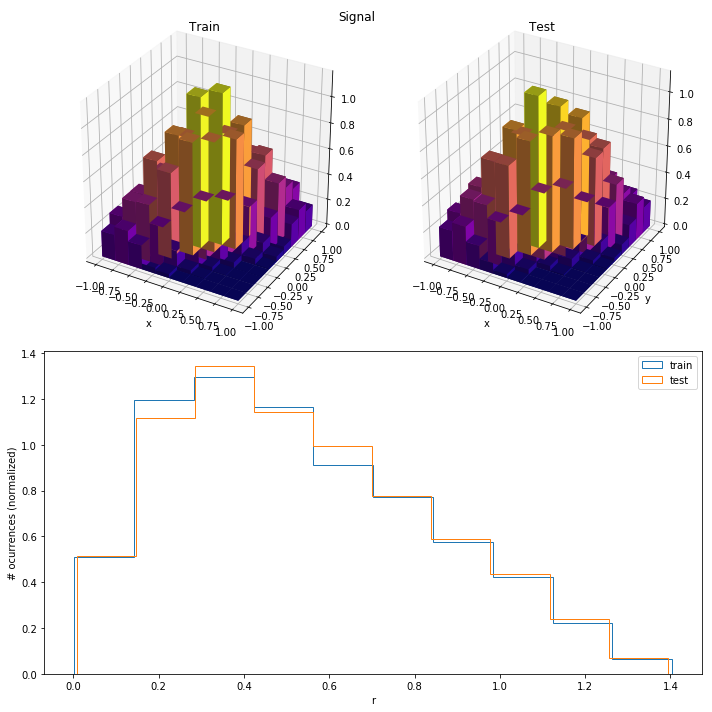

In [7]:
fig=plt.figure(figsize=(10,10))
fig.suptitle('Signal')
ax1=fig.add_subplot(221,projection='3d')
#ax1.hist2d(trnSX,trnSY)
hist3d(trnSX,trnSY,ax=ax1,fig=fig,cmap=cm.plasma,bins=10)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Train')
ax2=fig.add_subplot(222,projection='3d')
hist3d(tstSX,tstSY,ax=ax2,fig=fig,cmap=cm.plasma,bins=10)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Test')
ax3=fig.add_subplot(212)
ax3.hist(trnSR,normed=1,histtype='step',label='train')
ax3.hist(tstSR,normed=1,histtype='step',label='test')
ax3.set_xlabel('r')
ax3.set_ylabel('# ocurrences (normalized)')
ax3.legend()
plt.tight_layout()

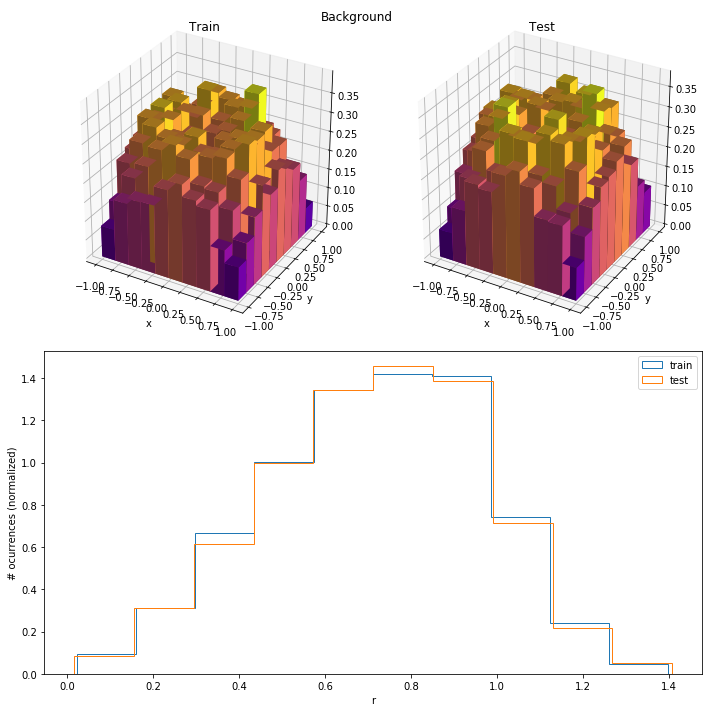

In [8]:
fig=plt.figure(figsize=(10,10))
fig.suptitle('Background')
ax1=fig.add_subplot(221,projection='3d')
hist3d(trnBX,trnBY,ax=ax1,fig=fig,bins=10,cmap=cm.plasma)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Train')
ax2=fig.add_subplot(222,projection='3d')
hist3d(tstBX,tstBY,ax=ax2,fig=fig,bins=10,cmap=cm.plasma)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Test')
ax3=fig.add_subplot(212)
ax3.hist(trnBR,normed=1,histtype='step',label='train')
ax3.hist(tstBR,normed=1,histtype='step',label='test')
ax3.set_xlabel('r')
ax3.set_ylabel('# ocurrences (normalized)')
ax3.legend()
plt.tight_layout()

### Kolmogorov

In [8]:
#For radial distance
Skol_r = stat.ks_2samp(trnSR,tstSR)
Bkol_r = stat.ks_2samp(trnBR,tstBR)
print Skol_r
print Bkol_r

Ks_2sampResult(statistic=0.018600000000000005, pvalue=0.062138623199628297)
Ks_2sampResult(statistic=0.0093999999999999917, pvalue=0.76711145525773772)


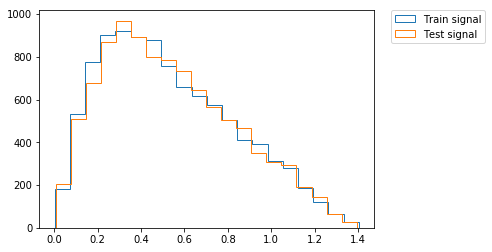

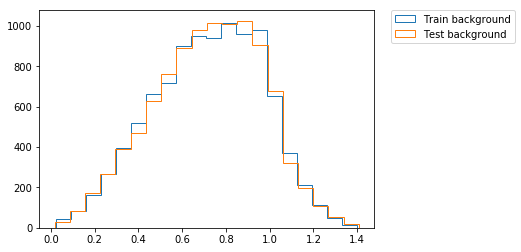

In [66]:
Nbins=20
plt.figure(1)
plt.hist(trnSR,  bins=Nbins, histtype="step", label='Train signal')
plt.hist(tstSR,  bins=Nbins, histtype="step", label='Test signal')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure(2)
plt.hist(trnBR,  bins=Nbins, histtype="step", label='Train background')
plt.hist(tstBR,  bins=Nbins, histtype="step", label='Test background')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

Comment the cases for which the p-value is very low (i.e. p < 0.01).

## Part c

$$\int _{-1}^1\int _{-1}^1e^{-6 x^2+10 x y-6 y^2}dxdy=0.86787$$

#### 2d midpoint integration
<img src="./images/Area_equivalence.jpeg" width="800">
<img src="./images/midpoint_part1.jpeg" width="800">
<img src="./images/midpoint_part2.jpeg" width="800">

In [9]:
# Definition of the T values for which to calculate alpha and beta
N = 100
rvec = np.linspace(1e-6,np.sqrt(2),N)
# initializate arrays for each method
alpha_int_r = np.empty(N)
beta_int_r = np.empty(N)
alpha_hist_r = np.empty(N)
beta_hist_r = np.empty(N)

# midpoint parameters
Tint_r = np.sqrt(Xint**2+Yint**2)

# histogram quadrature parameters
Nb_r = 100
T_bins_r = np.linspace(0, np.sqrt(2),Nb_r+1)
tstShist_r, tstShist_edges = np.histogram(tstSR,bins=T_bins_r,normed=1)
tstBhist_r, tstBhist_edges = np.histogram(tstBR,bins=T_bins_r,normed=1)
bin_width_r = tstShist_edges[1]-tstShist_edges[0]

In [10]:
for i,Tcut in enumerate(rvec):
    alpha_int_r[i], beta_int_r[i] = test_int(Tcut,tstSR,tstBR)
    alpha_hist_r[i], beta_hist_r[i] = hist_integral(Tcut,tstShist_r,tstBhist_r,T_bins_r)

stn_int_r = (1-alpha_int_r)/np.sqrt(beta_int_r)
stn_hist_r = (1-alpha_hist_r)/np.sqrt(beta_hist_r)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


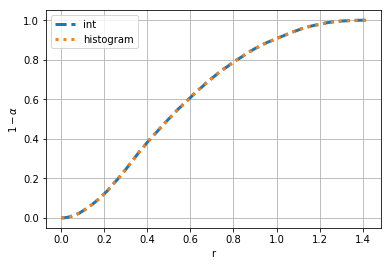

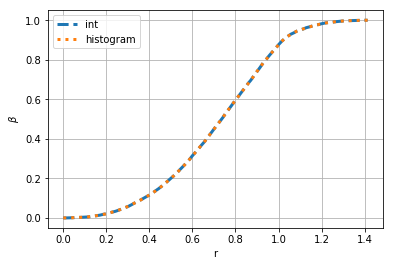

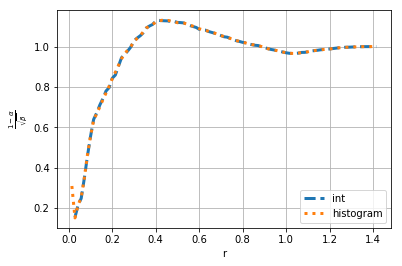

In [11]:
figs = [plt.figure(j+1) for j in range(3)]
ax1, ax2, ax3 = [fig.add_subplot(111) for fig in figs]
ax1.plot(rvec,1-alpha_int_r,'--',lw=3,label='int')
ax1.plot(rvec,1-alpha_hist_r,':',lw=3,label='histogram')
ax1.set_ylabel(r'$1-\alpha$')
ax2.plot(rvec,beta_int_r,'--',lw=3,label='int')
ax2.plot(rvec,beta_hist_r,':',lw=3,label='histogram')
ax2.set_ylabel(r'$\beta$')
ax3.plot(rvec,stn_int_r,'--',lw=3,label='int')
ax3.plot(rvec[1:],stn_hist_r[1:],':',lw=3,label='histogram')
ax3.set_ylabel(r'$\frac{1-\alpha}{\sqrt{\beta}}$')
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('r')
    ax.grid(True)
    ax.legend()

### Part d

 Maximize signal-to-noise ratio

In [12]:
# Maximize using test_int
Tcut_opt_int_r, stn_opt_int_r = find_maxima(stn_int_r,rvec)
# Maximize using hist_integration as integration method
Tcut_opt_hist_r, stn_opt_hist_r = find_maxima(stn_hist_r,rvec)

# Fischer discriminant

In [14]:
trnA, trnSfishdata, trnBfishdata, trnSCov, trnBCov = findFish(trnSX,trnSY,trnBX,trnBY)
tstA, tstSfishdata, tstBfishdata, tstSCov, tstBCov = findFish(tstSX,tstSY,tstBX,tstBY)
print(trnA)
print(tstA)

[ 1.23264075  0.08819874]
[ 1.21244883  0.09259129]


Note that $a$ is the same for both signal and background; the only difference in $a$ is between train and test.

Comment why using r and θ should be better than using x and y.

In [14]:
trnSCovXY = np.cov(np.array([trnSX,trnSY]))
trnBCovXY = np.cov(np.array([trnBX,trnBY]))
# now we compare rho, cause we have no other ideas 
print 'rhoSXY =',trnSCovXY[1,0]/np.sqrt(trnSCovXY[0,0]*trnSCovXY[1,1])
print 'rhoBXY =',trnBCovXY[1,0]/np.sqrt(trnBCovXY[0,0]*trnBCovXY[1,1])
print 'rhoSRtheta =',trnSCov[1,0]/np.sqrt(trnSCov[0,0]*trnSCov[1,1])
print 'rhoBRtheta =',trnBCov[1,0]/np.sqrt(trnBCov[0,0]*trnBCov[1,1])

rhoSXY = 0.766766629111
rhoBXY = 0.00674822012294
rhoSRtheta = 0.317541812512
rhoBRtheta = 0.00419389430949


The input of the Komogorov test is the T shown below:
<img src="./images/T_fisher.png" width="200">

In [15]:
#For the Fisher discriminant
Skol_fish = stat.ks_2samp(fisherTest(trnSfishdata,trnA),
                          fisherTest(tstSfishdata,tstA))

Bkol_fish = stat.ks_2samp(fisherTest(trnBfishdata,trnA),
                          fisherTest(tstBfishdata,tstA))

print Skol_fish
print Bkol_fish

Ks_2sampResult(statistic=0.016900000000000026, pvalue=0.11383953794374878)
Ks_2sampResult(statistic=0.012299999999999978, pvalue=0.43364421737670955)


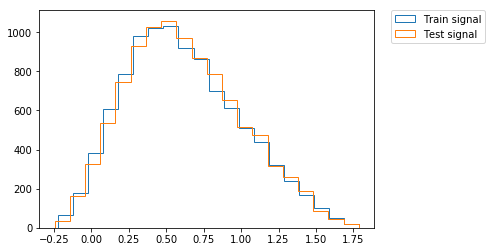

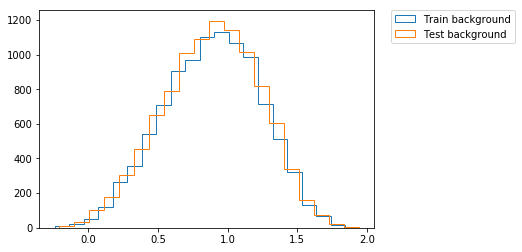

In [67]:
Nbins=20
plt.figure(1)
plt.hist(fisherTest(trnSfishdata,trnA),  bins=Nbins, histtype="step", label='Train signal')
plt.hist(fisherTest(tstSfishdata,trnA),  bins=Nbins, histtype="step", label='Test signal')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure(2)
plt.hist(fisherTest(trnBfishdata,trnA),  bins=Nbins, histtype="step", label='Train background')
plt.hist(fisherTest(tstBfishdata,trnA),  bins=Nbins, histtype="step", label='Test background')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

Comment the cases for which the p-value is very low (i.e. p < 0.01).

Analysis of p-values: TBD

In [21]:
Ta=fisherTest(trnSfishdata,trnA)

Tcuts = np.linspace(np.sort(Ta)[0],np.sort(Ta)[-1],100)

alpha_int_fish = np.empty_like(Tcuts)
beta_int_fish = np.empty_like(Tcuts)
alpha_hist_fish = np.empty_like(Tcuts)
beta_hist_fish = np.empty_like(Tcuts) 

# midpoint parameters
Tint_fish = np.empty_like(Xint)
for i,xvec in enumerate(Xint):
    Tint_fish[i,:]=fisherTest(np.array([np.sqrt(xvec**2 + Yint[i,0]**2),np.arctan2(Yint[i,0],xvec)]),trnA) 

# histogram quadrature parameters
Nb_fish = 25
T_bins_fish = np.linspace(min(Tcuts), max(Tcuts),Nb_fish+1)
tstST_fish = fisherTest(tstSfishdata,trnA)
tstBT_fish = fisherTest(tstBfishdata,trnA)
tstShist_fish, edges = np.histogram(tstST_fish,bins=T_bins_fish,normed=1)
tstBhist_fish, edges = np.histogram(tstBT_fish,bins=T_bins_fish,normed=1)

In [22]:
for i,Tcut in enumerate(Tcuts):
    alpha_int_fish[i], beta_int_fish[i] = test_int(Tcut,tstST_fish,tstBT_fish)
    alpha_hist_fish[i], beta_hist_fish[i] = hist_integral(Tcut,tstShist_fish,tstBhist_fish,T_bins_fish)
    
stn_int_fish = (1-alpha_int_fish)/np.sqrt(beta_int_fish)
stn_hist_fish = (1-alpha_hist_fish)/np.sqrt(beta_hist_fish)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


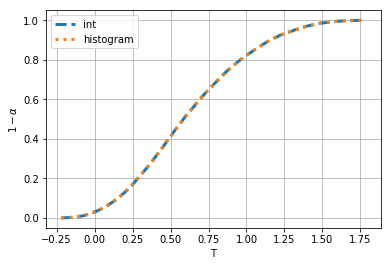

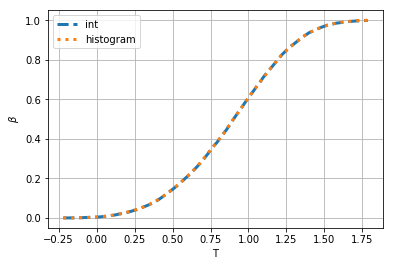

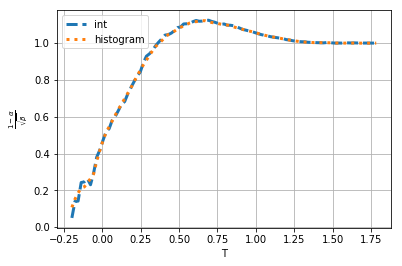

In [23]:
figs = [plt.figure(j+1) for j in range(3)]
ax1, ax2, ax3 = [fig.add_subplot(111) for fig in figs]
ax1.plot(Tcuts,1-alpha_int_fish,'--',lw=3,label='int')
ax1.plot(Tcuts,1-alpha_hist_fish,':',lw=3,label='histogram')
ax1.set_ylabel(r'$1-\alpha$')
ax2.plot(Tcuts,beta_int_fish,'--',lw=3,label='int')
ax2.plot(Tcuts,beta_hist_fish,':',lw=3,label='histogram')
ax2.set_ylabel(r'$\beta$')
ax3.plot(Tcuts[1:],stn_int_fish[1:],'--',lw=3,label='int')
ax3.plot(Tcuts[1:],stn_hist_fish[1:],':',lw=3,label='histogram')
ax3.set_ylabel(r'$\frac{1-\alpha}{\sqrt{\beta}}$')
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('T')
    ax.grid(True)
    ax.legend()

In [57]:
# Maximize using test_int
Tcut_opt_int_fish, stn_opt_int_fish = find_maxima(stn_int_fish,rvec)
# Maximize using hist_integration as integration method
Tcut_opt_hist_fish, stn_opt_hist_fish = find_maxima(stn_hist_fish,rvec)

print(Tcut_opt_int_fish,Tcut_opt_hist_fish)
print(stn_opt_int_fish,stn_opt_hist_fish)

0.642824891988 0.614254941233
1.12448491642 1.12232411277


# Exact likelihood ratio

In [35]:
#for edges of Tcut
Tint_like = log_lambda(Xint,Yint)
#for Tcut loop
Tcut_max = np.max(np.max(Tint_like))
Tcut_min = np.min(np.min(Tint_like))
Tcuts_like = np.linspace(Tcut_min,Tcut_max,100)
alpha_int_like = np.empty_like(Tcuts_like)
beta_int_like = np.empty_like(Tcuts_like)
alpha_hist_like = np.empty_like(Tcuts_like)
beta_hist_like = np.empty_like(Tcuts_like)
# for hist integration
T_bins_like = np.linspace(Tcut_min,Tcut_max,100)
tstST_like = log_lambda(tstSX,tstSY)
tstBT_like = log_lambda(tstBX,tstBY)
tstShist_like,edges  = np.histogram(tstST_like,bins=T_bins_like,normed=1)
tstBhist_like,edges = np.histogram(tstBT_like,bins=T_bins_like,normed=1)

In [26]:
# exact likelihood kolmogorov
# with loh_like
Skol_like = stat.ks_2samp(tstST_like,log_lambda(trnSX,trnSY))
Bkol_like = stat.ks_2samp(tstBT_like,log_lambda(trnBX,trnBY))

print Skol_like
print Bkol_like
# with like
Skol_like_lin = stat.ks_2samp(lambda_exact(trnSX,trnSY),lambda_exact(tstSX,tstSY))
Bkol_like_lin = stat.ks_2samp(lambda_exact(trnBX,trnBY),lambda_exact(tstBX,tstBY))

print Skol_like_lin
print Bkol_like_lin

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(Skol_like)? (<ipython-input-26-677e9f820024>, line 6)

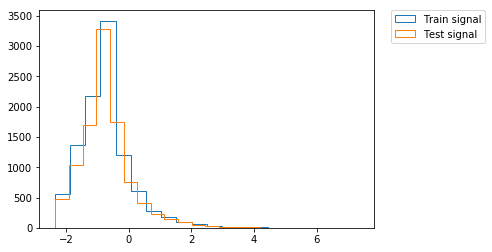

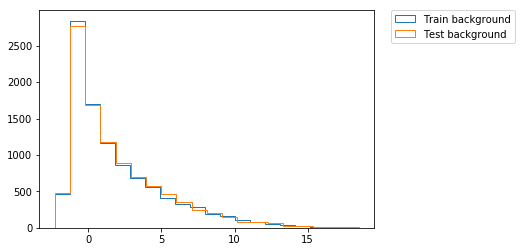

In [68]:
Nbins=20
plt.figure(1)
plt.hist(log_lambda(trnSX,trnSY),  bins=Nbins, histtype="step", label='Train signal')
plt.hist(tstST_like,  bins=Nbins, histtype="step", label='Test signal')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure(2)
plt.hist(log_lambda(trnBX,trnBY),  bins=Nbins, histtype="step", label='Train background')
plt.hist(tstBT_like,  bins=Nbins, histtype="step", label='Test background')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Kolmogorov da lo mismo para log y para lin!!!!!!!!

In [36]:
for i,Tcut in enumerate(Tcuts_like):
    alpha_int_like[i], beta_int_like[i] = test_int(Tcut,tstST_like,tstBT_like)
    alpha_hist_like[i], beta_hist_like[i] = hist_integral(Tcut,tstShist_like,tstBhist_like,T_bins_like)

stn_int_like = (1-alpha_int_like)/np.sqrt(beta_int_like)
stn_hist_like = (1-alpha_hist_like)/np.sqrt(beta_hist_like)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


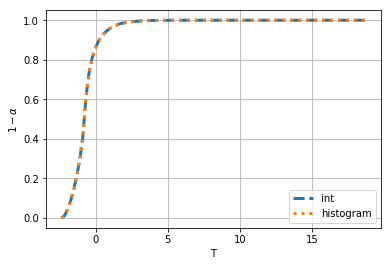

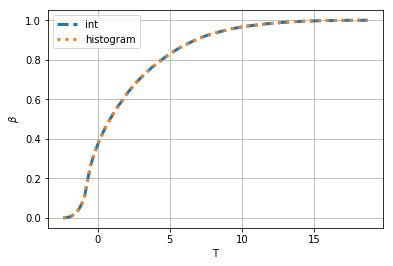

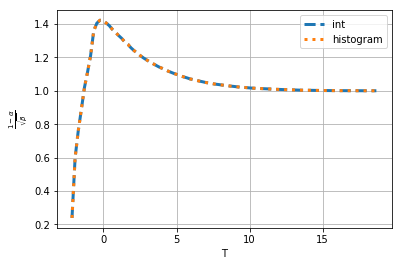

In [37]:
figs = [plt.figure(j+1) for j in range(3)]
ax1, ax2, ax3 = [fig.add_subplot(111) for fig in figs]
ax1.plot(Tcuts_like,1-alpha_int_like,'--',lw=3,label='int')
ax1.plot(Tcuts_like,1-alpha_hist_like,':',lw=3,label='histogram')
ax1.set_ylabel(r'$1-\alpha$')
ax2.plot(Tcuts_like,beta_int_like,'--',lw=3,label='int')
ax2.plot(Tcuts_like,beta_hist_like,':',lw=3,label='histogram')
ax2.set_ylabel(r'$\beta$')
ax3.plot(Tcuts_like[1:],stn_int_like[1:],'--',lw=3,label='int')
ax3.plot(Tcuts_like[1:],stn_hist_like[1:],':',lw=3,label='histogram')
ax3.set_ylabel(r'$\frac{1-\alpha}{\sqrt{\beta}}$')
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('T')
    ax.grid(True)
    ax.legend()

In [51]:
Tcut_opt_int_like, stn_opt_int_like = find_maxima(stn_int_like,Tcuts_like)
Tcut_opt_hist_like, stn_opt_hist_like = find_maxima(stn_hist_like,Tcuts_like)
print(Tcut_opt_int_like, stn_opt_int_like)
print(Tcut_opt_hist_like, stn_opt_hist_like)

-0.241842271307 1.42228762396
-0.241842271307 1.42228762396


## Estimated likelihood

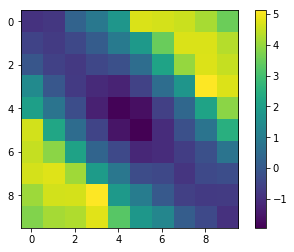

In [38]:
trnShist2d, xedges, yedges = np.histogram2d(trnSX, trnSY, bins=bins_edgesXY_est, normed=1)
trnBhist2d, xedges, yedges = np.histogram2d(trnBX, trnBY, bins=bins_edgesXY_est, normed=1)
dint = bins_edgesXY_est[1]-bins_edgesXY_est[0]
trnShist2d[trnShist2d==0] = 2e-3 # NOTE: we are substituting cell equal to zero by 2e-3, this way, we have no infinite
# values in the lambda estimation due to zero division. The value 2e-3 is the one that fits better the histogram
norm_factor = sum(sum(trnShist2d))*dint**2
trnLAMBDAhist2d = np.log(trnBhist2d)-np.log(trnShist2d)+np.log(norm_factor)
plt.imshow(trnLAMBDAhist2d)
plt.colorbar()

In [39]:
#for Tcut limits
Tint_est = estimated_log_lambda_array(Xint,Yint)
#for Tcut loop
Tcut_max = np.max(np.max(Tint_est))
Tcut_min = np.min(np.min(Tint_est))
Tcuts_est = np.linspace(Tcut_min,Tcut_max,100)
alpha_int_est = np.empty_like(Tcuts_est)
beta_int_est = np.empty_like(Tcuts_est)
alpha_hist_est = np.empty_like(Tcuts_est)
beta_hist_est = np.empty_like(Tcuts_est)
# for hist integration
T_bins_est = np.linspace(Tcut_min,Tcut_max,100)
tstST_est = estimated_log_lambda_array(tstSX,tstSY)
tstBT_est = estimated_log_lambda_array(tstBX,tstBY)
tstShist_est,edges  = np.histogram(tstST_est,bins=T_bins_est,normed=1)
tstBhist_est,edges = np.histogram(tstBT_est,bins=T_bins_est,normed=1)

In [30]:
# estimated estlikelihood kolmogorov
Skol_est = stat.ks_2samp(tstST_est,estimated_log_lambda_array(trnSX,trnSY))
Bkol_est = stat.ks_2samp(tstBT_est,estimated_log_lambda_array(trnBX,trnBY))

print Skol_est
print Bkol_est

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(Skol_est)? (<ipython-input-30-ffc3e7c8c07c>, line 5)

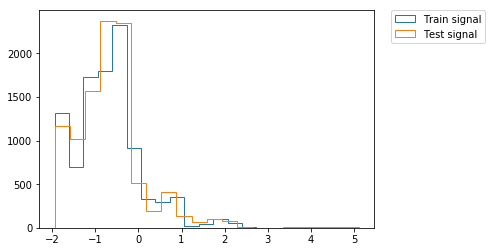

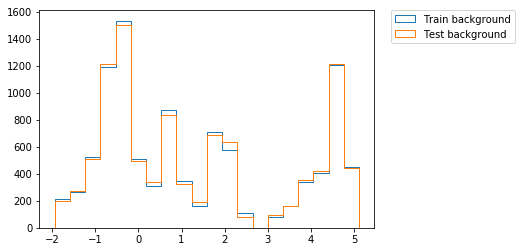

In [69]:
Nbins=20
plt.figure(1)
plt.hist(estimated_log_lambda_array(trnSX,trnSY),  bins=Nbins, histtype="step", label='Train signal')
plt.hist(tstST_est,  bins=Nbins, histtype="step", label='Test signal')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure(2)
plt.hist(estimated_log_lambda_array(trnBX,trnBY),  bins=Nbins, histtype="step", label='Train background')
plt.hist(tstBT_est,  bins=Nbins, histtype="step", label='Test background')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [40]:
for i,Tcut in enumerate(Tcuts_est):
    alpha_int_est[i], beta_int_est[i] = test_int(Tcut,tstST_est,tstBT_est)
    alpha_hist_est[i], beta_hist_est[i] = hist_integral(Tcut,tstShist_est,tstBhist_est,T_bins_est)

stn_int_est = (1-alpha_int_est)/np.sqrt(beta_int_est)
stn_hist_est = (1-alpha_hist_est)/np.sqrt(beta_hist_est)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


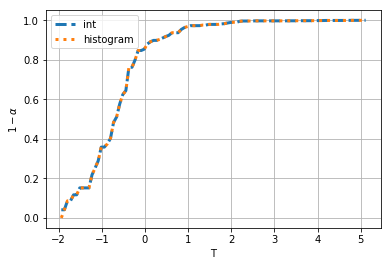

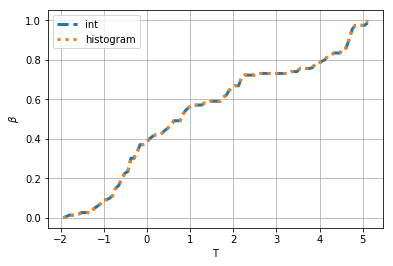

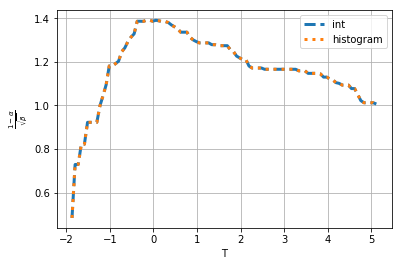

In [41]:
figs = [plt.figure(j+1) for j in range(3)]
ax1, ax2, ax3 = [fig.add_subplot(111) for fig in figs]
ax1.plot(Tcuts_est,1-alpha_int_est,'--',lw=3,label='int')
ax1.plot(Tcuts_est,1-alpha_hist_est,':',lw=3,label='histogram')
ax1.set_ylabel(r'$1-\alpha$')
ax2.plot(Tcuts_est,beta_int_est,'--',lw=3,label='int')
ax2.plot(Tcuts_est,beta_hist_est,':',lw=3,label='histogram')
ax2.set_ylabel(r'$\beta$')
ax3.plot(Tcuts_est[1:],stn_int_est[1:],'--',lw=3,label='int')
ax3.plot(Tcuts_est[1:],stn_hist_est[1:],':',lw=3,label='histogram')
ax3.set_ylabel(r'$\frac{1-\alpha}{\sqrt{\beta}}$')
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('T')
    ax.grid(True)
    ax.legend()

In [50]:
Tcut_opt_int_est, stn_opt_int_est = find_maxima(stn_int_est,Tcuts_est)
Tcut_opt_hist_est, stn_opt_hist_est = find_maxima(stn_hist_est,Tcuts_est)
print(Tcut_opt_int_est, stn_opt_int_est)
print(Tcut_opt_hist_est, stn_opt_hist_est)

-0.158679249661 1.39097985348
-0.158679249661 1.39097985348


## Neural Networks

In [43]:
# Scale the data (recommended for NN stability)
# define the scale
scaler = preproc.StandardScaler() 
scaler.fit(trnB) 

# apply the scale
trnSXY_scaled = scaler.transform(trnS)
trnBXY_scaled = scaler.transform(trnB)


# Define and train the NN

# put it all in one simple train data sample:
trnXY_scaled_all = np.append(trnSXY_scaled,trnBXY_scaled,axis=0)
type_all     = np.append(np.zeros(trnSXY_scaled.shape[0]),
                         np.ones(trnSXY_scaled.shape[0]))

# create the NN and train it with the training data
clf = nn.MLPRegressor(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(5,3),
                      random_state=1)
clf.fit(trnXY_scaled_all,type_all)

# evaluate the NN test statistic 
#data    = tstB
#sc_data = scaler.transform(data)
#clf_data= clf.predict(sc_data)
#print("{:^20}  {:>15}".format("   data","NN classifier"))
#print("{:^20}  {:>15}".format("  ********","*************"))
#for dataval,clfval in zip(data,clf_data) :
#    print("{:>20}  {:^15.2f}".format(str(dataval),clfval))

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [44]:
#for Tcut limits
flatX = Xint.flatten('C')
flatY = Yint.flatten('C')
sc_data = scaler.transform(np.transpose(np.array([flatX,flatY])))
Tvalue_nn = clf.predict(sc_data)
Tint_nn = np.reshape(Tvalue_nn,Xint.shape,'C')
#for Tcut loop
Tcut_max = np.max(np.max(Tint_nn))
Tcut_min = np.min(np.min(Tint_nn))
Tcuts_nn = np.linspace(Tcut_min,Tcut_max,100)
alpha_int_nn = np.empty_like(Tcuts_nn)
beta_int_nn = np.empty_like(Tcuts_nn)
alpha_hist_nn = np.empty_like(Tcuts_nn)
beta_hist_nn = np.empty_like(Tcuts_nn)
# for hist integration
T_bins_nn = np.linspace(Tcut_min,Tcut_max,100)
tstST_nn = clf.predict(scaler.transform(tstS))
tstBT_nn = clf.predict(scaler.transform(tstB))
tstShist_nn,edges  = np.histogram(tstST_nn,bins=T_bins_nn,normed=1)
tstBhist_nn,edges = np.histogram(tstBT_nn,bins=T_bins_nn,normed=1)

In [45]:
# neural network
Skol_nn = stat.ks_2samp(tstST_nn,clf.predict(scaler.transform(trnS)))
Bkol_nn = stat.ks_2samp(tstBT_nn,clf.predict(scaler.transform(trnB)))

print Skol_nn
print Bkol_nn

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(Skol_nn)? (<ipython-input-45-d2cf32ba160a>, line 5)

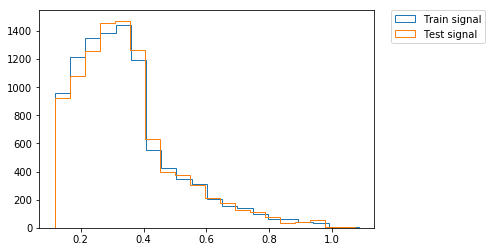

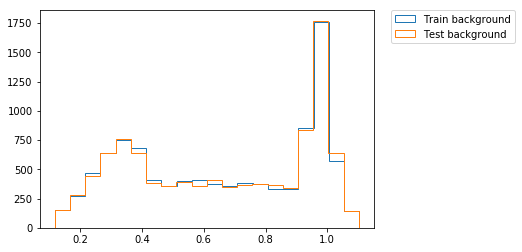

In [70]:
Nbins=20
plt.figure(1)
plt.hist(clf.predict(scaler.transform(trnS)),  bins=Nbins, histtype="step", label='Train signal')
plt.hist(tstST_nn,  bins=Nbins, histtype="step", label='Test signal')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure(2)
plt.hist(clf.predict(scaler.transform(trnB)),  bins=Nbins, histtype="step", label='Train background')
plt.hist(tstBT_nn,  bins=Nbins, histtype="step", label='Test background')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [46]:
for i,Tcut in enumerate(Tcuts_nn):
    alpha_int_nn[i], beta_int_nn[i] = test_int(Tcut,tstST_nn,tstBT_nn)
    alpha_hist_nn[i], beta_hist_nn[i] = hist_integral(Tcut,tstShist_nn,tstBhist_nn,T_bins_nn)

stn_int_nn = (1-alpha_int_nn)/np.sqrt(beta_int_nn)
stn_hist_nn = (1-alpha_hist_nn)/np.sqrt(beta_hist_nn)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


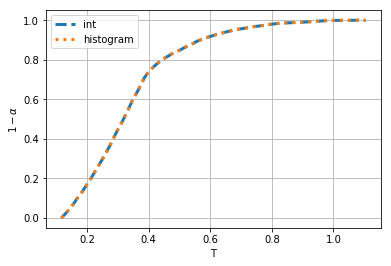

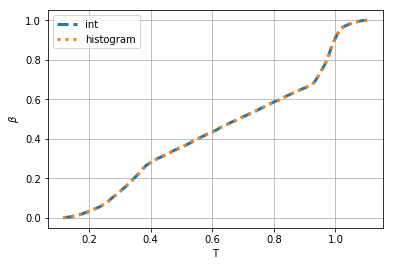

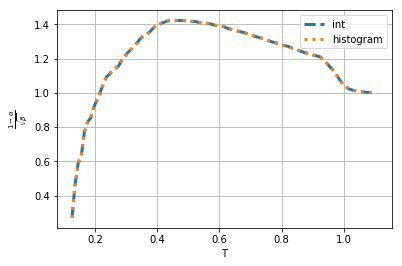

In [47]:
figs = [plt.figure(j+1) for j in range(3)]
ax1, ax2, ax3 = [fig.add_subplot(111) for fig in figs]
ax1.plot(Tcuts_nn,1-alpha_int_nn,'--',lw=3,label='int')
ax1.plot(Tcuts_nn,1-alpha_hist_nn,':',lw=3,label='histogram')
ax1.set_ylabel(r'$1-\alpha$')
ax2.plot(Tcuts_nn,beta_int_nn,'--',lw=3,label='int')
ax2.plot(Tcuts_nn,beta_hist_nn,':',lw=3,label='histogram')
ax2.set_ylabel(r'$\beta$')
ax3.plot(Tcuts_nn[1:],stn_int_nn[1:],'--',lw=3,label='int')
ax3.plot(Tcuts_nn[1:],stn_hist_nn[1:],':',lw=3,label='histogram')
ax3.set_ylabel(r'$\frac{1-\alpha}{\sqrt{\beta}}$')
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('T')
    ax.grid(True)
    ax.legend()

In [52]:
Tcut_opt_int_nn, stn_opt_int_nn = find_maxima(stn_int_nn,Tcuts_nn)
Tcut_opt_hist_nn, stn_opt_hist_nn = find_maxima(stn_hist_nn,Tcuts_nn)
print(Tcut_opt_int_nn, stn_opt_int_nn)
print(Tcut_opt_hist_nn, stn_opt_hist_nn)

0.455968304637 1.42311590581
0.455968304637 1.42311590581


## Part b

### Summary of p-values

In [ ]:
print "P-values from the Komogorov test:"

#For radial distance
print "* For Radial distance *"
print '\tSignal : %g' %Skol_r[1]
print '\tBackground : %g' %Bkol_r[1]

#For Fisher discriminant
print "* For Fisher discriminant *"
print '\tSignal : %g' %Skol_fish[1]
print '\tBackground : %g' %Bkol_fish[1]

#For exact likelihood
print "* For exact likelihood *"
print '\tSignal : %g' %Skol_like[1]
print '\tBackground : %g' %Bkol_like[1]

#For estimated likelihood
print "* For estimated likelihood *"
print '\tSignal : %g' %Skol_est[1]
print '\tBackground : %g' %Bkol_est[1]

#For neural network
print "* For neural network *"
print '\tSignal : %g' %Skol_nn[1]
print '\tBackground : %g' %Bkol_nn[1]

### Part e
Compare the performance of the different test statistics by plotting together their signal-to-noise ratio vs. (1 − α) curves. 

Comment on the result: which test is better and why do we get the order we get.

Text(0,0.5,'$\\frac{1-\\alpha}{\\sqrt{\\beta}}$')

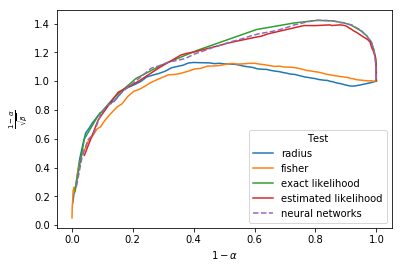

In [53]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.plot(1-alpha_int_r,stn_int_r,label='radius')
ax.plot(1-alpha_int_fish[1:],stn_int_fish[1:],label='fisher')
ax.plot(1-alpha_int_like[1:],stn_int_like[1:],label='exact likelihood')
ax.plot(1-alpha_int_est[1:],stn_int_est[1:],label='estimated likelihood')
ax.plot(1-alpha_int_nn[1:],stn_int_nn[1:],'--',label='neural networks')
ax.legend(title='Test')
ax.set_xlabel(r'$1-\alpha$')
ax.set_ylabel(r'$\frac{1-\alpha}{\sqrt{\beta}}$')

Comment on the result: which test is better and why do we get the order we get.

From better to worse: exact, nn, estimated, fisher or/and radius (the last two are USELESS, or BASURA as alexis says)

### Part f
For each test statistic, draw the boundaries of the critical region defined by Tcut, in the (x,y) plane. Comment about the reason for the shape of the critical region in each case.

In [54]:
Tint_plot_r = np.copy(Tint_r)
Tint_plot_r[Tint_r<Tcut_opt_int_r] = 0
Tint_plot_r[Tint_r>=Tcut_opt_int_r] = 1

Tcut_opt_hist_fish = 0.5*max(Tcuts)
Tint_plot_fish = np.copy(Tint_fish)
Tint_plot_fish[Tint_fish<Tcut_opt_hist_fish] = 0
Tint_plot_fish[Tint_fish>=Tcut_opt_hist_fish] = 1

Tint_plot_like = np.copy(Tint_like)
Tint_plot_like[Tint_like<Tcut_opt_int_like] = 0
Tint_plot_like[Tint_like>=Tcut_opt_int_like] = 1

Tint_plot_est = np.copy(Tint_est)
Tint_plot_est[Tint_est<Tcut_opt_int_est] = 0
Tint_plot_est[Tint_est>=Tcut_opt_int_est] = 1

Tint_plot_nn = np.copy(Tint_nn)
Tint_plot_nn[Tint_nn<Tcut_opt_int_nn] = 0
Tint_plot_nn[Tint_nn>=Tcut_opt_int_nn] = 1

E:\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


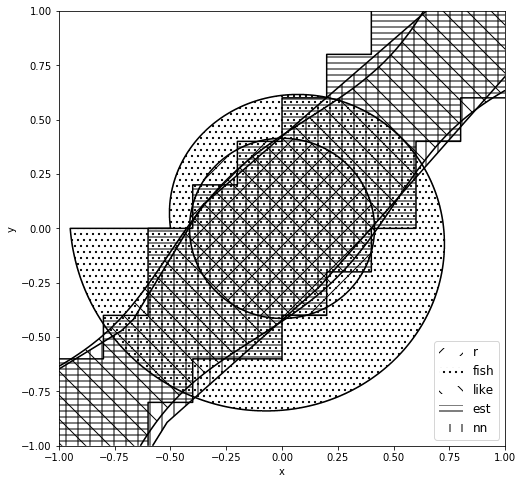

In [56]:
# Plot 2D function (joint X-Y pdf) as contours
colorines = ['k','r','k','r','b']
rayados = ['/','..','\\','--','|']
plot_hatches = [[raya,None] for raya in rayados]
plt.figure(figsize=(8,8))
r_plot = plt.contourf(Xint, Yint, Tint_plot_r, 1, colors='none',hatches=plot_hatches[0])
plt.contour(Xint, Yint, Tint_plot_r, 1, colors='black', linewidth=.2)

fish_plot = plt.contourf(Xint, Yint, Tint_plot_fish, 1, colors='none',hatches=plot_hatches[1])
plt.contour(Xint, Yint, Tint_plot_fish, 1, colors='black', linewidth=.2)

like_plot = plt.contourf(Xint, Yint, Tint_plot_like, 1, colors='none',hatches=plot_hatches[2])
plt.contour(Xint, Yint, Tint_plot_like, 1, colors='black', linewidth=.2)

est_plot = plt.contourf(Xint, Yint, Tint_plot_est, 1, colors='none', hatches=plot_hatches[3])
plt.contour(Xint, Yint, Tint_plot_est, 1, colors='black', linewidth=.2)

nn_plot = plt.contourf(Xint, Yint, Tint_plot_nn, 1, colors='none',hatches=plot_hatches[4])
plt.contour(Xint, Yint, Tint_plot_nn, 1, colors='black', linewidth=.2)


#C = plt.contour(Xint, Yint, Tint_plot_r, 1, colors='black', linewidth=.5)
#plt.clabel(C, inline=1, fontsize=10)
plt.xlabel('x')
plt.ylabel('y')
leg = []
Tests = ['r','fish','like','est','nn']
for i,raya in enumerate(rayados):
    leg.append(mpatches.Patch(facecolor='w', hatch=raya, label=Tests[i]))
plt.legend(handles=leg,loc=4,fontsize='large')

### Part g


In [40]:
dataOn = np.loadtxt('Block3_data/data_On.txt',skiprows=2,usecols=(0,1,2))
dataOff = np.loadtxt('Block3_data/data_Off.txt',skiprows=2,usecols=(0,1,2))

We are going to use the exact likelyhood ratio, cause we consider it is the best. Therefore, our filter has the following properties:

In [41]:
print 'lambda_cut=%.3f' %np.exp(Tcut_opt_int_like)
alpha_test_opt,beta_test_opt = midpoint2d(Tcut_opt_int_like,Tint_like)
print 'The parameters corresponding to this lambda cut are:\n\talpha=%.3f\n\tbeta=%.3f' %(alpha_test_opt,beta_test_opt)

lambda_cut=0.785
The parameters corresponding to this lambda cut are:
	alpha=0.189
	beta=0.323


Remember: alpha indicates the probability of fake negatives (that is, rejecting a signal point)

and beta indicates the probability of fake positives (that is, accepting a background as signal)

In [47]:
# calculamos el valor de lambda para cada dato
log_lambdaOn = log_lambda(dataOn[:,0],dataOn[:,1])
log_lambdaOff = log_lambda(dataOff[:,0],dataOff[:,1])

# filter the data in order to save only the values outside the critical region
dataOn_filtered = dataOn[log_lambdaOn<Tcut_opt_int_like,:]
dataOff_filtered = dataOff[log_lambdaOff<Tcut_opt_int_like,:]

Ns = (len(dataOn_filtered)-len(dataOn)*beta_test_opt)/(1.-alpha_test_opt-beta_test_opt) # Ns is the number of 
# signal events in dataOn
print 'According to theoretical alpha and beta, the number of signal events in dataOn_filtered \
is %d' %(Ns*(1-alpha_test_opt))
print 'According to background from dataOff, the number of signal events in dataOn_filtered \
is %d' %(len(dataOn_filtered)-len(dataOff_filtered)/3.)

According to theoretical alpha and beta, the number of signal events in dataOn_filtered is 42
According to background from dataOff, the number of signal events in dataOn_filtered is 47


We estimate the number of signal events in the filtered data with 2 different approaches:
 1. We know that $N=N_s+N_b$, being $N$ the total number of events in dataOn, and $N_s$ and $N_b$ the number of signal and background events in dataOn respectively. Therefore, tha number of events in the filtered sample dataOn_filtered ($N_f$) will be $N_f=N_s(1-\alpha)+N_b\beta$. Then, as $N_b=N-N_s$ we find that $N_s=\frac{N_f-N\beta}{1-\alpha-\beta}$. Finally, the number of signal values in dataOn_filtered will be $N_s(1-\alpha)$
 2. We have two samples, On and Off, and Off sample does only contain background, but for a time 3 times larger than the time of the On sample. Therefore, we can estimate how good our test filters from Off. Therefore, the number of signal events in dataOn_filtered will be len(dataOn_filtered)-len(dataOff_filtered)/3, because the estimated number of background events in dataOn_filtered is len(dataOff_filtered)/3

In [43]:
pvalue_filtered = np.empty(len(dataOn_filtered))
for i,(x,y,e) in enumerate(dataOn_filtered):
    Tpoint = log_lambda(x,y)
    pvalue_filtered[i] , beta = midpoint2d(Tpoint,Tint_like)

In [48]:
print alpha_test_opt
print min(pvalue_filtered)
print 1-(1-min(pvalue_filtered))**len(dataOn_filtered)

0.188868000399
0.189279782719
1.0


In [49]:
pvalue_not_filtered = np.empty(len(dataOn))
for i,(x,y,e) in enumerate(dataOn):
    Tpoint = log_lambda(x,y)
    pvalue_not_filtered[i] , beta = midpoint2d(Tpoint,Tint_like)

In [50]:
print alpha_test_opt
print min(pvalue_not_filtered)
print 1-(1-min(pvalue_not_filtered))**len(dataOn)

0.188868000399
2.20463126882e-13
2.30853336447e-10


For crosscheck: S= 2.265

TODO: Averiguar que cojones preunta al final de la parte g)

# Ejercicio 2
## Part a


TODO: preguntar qué hay que hacer en este ejercicio